## Environment Details

* **OS : Windows**
* **CPU : i7 6700HQ ~2.60GHz**
* **GPU : GTX 1060 6GB**
* **RAM : 16GB**

## Dependencies

* **tensorflow : 2.2.1**
* **numpy : 1.18.1**
* **matplotlib : 3.1.3**

## Dataset Details :

Trained and tested model on the American Sign Language Dataset. Its a dataset of $24$ classes, containing images of $28 \times 28$ shape and its big enough to experiment with different dataset sizes on this Siamese Network. You can check the dataset [here](https://www.kaggle.com/datamunge/sign-language-mnist). 

## Find available GPUs and set memory growth to optimal

Because, by default tensorflow is very memory hungry and will allocate everything without considering optimality.

In [1]:
import tensorflow as tf

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Build the Siamese Model Architecture

The working has been explained in the [README](https://github.com/sudoRicheek/Siamese-Net-One-Shot-Learning/blob/master/README.md).

In [5]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy

import numpy.random as rng
import numpy as np

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
%matplotlib inline

def W_init(shape,dtype=None):
    #---->Random Initialization of weights
    values = rng.normal(loc=0,scale=1e-1,size=shape)
    return K.variable(values,dtype=dtype)

def b_init(shape,dtype=None):
    #---->Random Initialization of Network Biases
    values=rng.normal(loc=0.5,scale=1e-1,size=shape)
    return K.variable(values,dtype=dtype)

#---->Build the Siamese Legs
input_shape = (28, 28, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

#---->Now we need a convolutional network for the Siamese Legs
convnet = Sequential()
convnet.add(Conv2D(64,(7,7),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(3,3),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init,padding='same'))
convnet.add(Flatten())
convnet.add(Dense(1024,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))


#---->Now we call the convnet using each leg, so the parameters get shared.
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

#---->Layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

#---->Get the L1 Distance between the two encoded legs and predict a sigmoid using that.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)

#---->Now we build the Siamese Model using the two legs as inputs and the final comparison prediction.
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

#---->We should have tried out even more hyperparamter tuning by setting learning rates and momentum params 
#---->for each convolutional layer. But for now we use a standard Adam optimizer in default settings.
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()

4625921

## Get the train and test CSV

In [5]:
train_file_path = "C:/Users/Richeek Das/Downloads/asl/sign_mnist_train.csv"
test_file_path = "C:/Users/Richeek Das/Downloads/asl/sign_mnist_test.csv"

In [6]:
import pandas as pd
import numpy as np

In [7]:
X_train = pd.read_csv(train_file_path)
X_test = pd.read_csv(test_file_path)

#---->Set DATASET TRAIN and VALIDATION sizes
TRAIN_DATASET_SIZE_PER_CLASS = 125
VALID_DATASET_SIZE_PER_CLASS = 50

## Preprocess the DataSets

First we, reshape the target images into (28, 28)

In [8]:
#---->Extracting the labels from the data
y_train = X_train["label"]
y_test = X_test["label"]

#---->Dropping the labels from the X_train and X_test dataframe
X_train.drop(columns = ["label"], inplace = True)
X_test.drop(columns = ["label"], inplace = True)

X_train = X_train/255
X_test = X_test/255

#---->Reshaping the data from (m,784) to (m,28,28)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

### Get an inverse mapping of the categories to be encoded

In [9]:
#---->Get the index list and get an inverse mapping for it
index_list = y_train.unique().tolist()          
inverse_index_list = np.zeros(25, dtype=int)

for i,k in enumerate(index_list) :
    inverse_index_list[k] = i

### Fill the multi-dimensional arrays to be used

Here we fill the Train, Valid and Test Sets, according to the DATASET_SIZE_PER_CLASS parameter.

In [10]:
#---->Train Set
X_fill_calc = np.zeros(25, dtype=int)
X_train_new = np.zeros((24,TRAIN_DATASET_SIZE_PER_CLASS,28,28,1))

for i, cat in enumerate(y_train.tolist()) :
    if(X_fill_calc[cat] < TRAIN_DATASET_SIZE_PER_CLASS):
        X_train_new[inverse_index_list[cat]][X_fill_calc[cat]] = X_train[i]
        X_fill_calc[cat] = X_fill_calc[cat] + 1

In [12]:
#---->Valid Set
X_fill_calc = np.zeros(25, dtype=int)
X_valid_new = np.zeros((24,VALID_DATASET_SIZE_PER_CLASS,28,28,1))

for i, cat in enumerate(y_test.tolist()) :
    if(X_fill_calc[cat] < VALID_DATASET_SIZE_PER_CLASS):
        X_valid_new[inverse_index_list[cat]][X_fill_calc[cat]] = X_test[i]
        X_fill_calc[cat] = X_fill_calc[cat] + 1

In [13]:
#---->Test Set
X_fill_calc = np.zeros(25, dtype=int)
X_test_new = np.zeros((24,200,28,28,1))

for i, cat in enumerate(y_train.tolist()) :
    if(X_fill_calc[cat] >= 250 and X_fill_calc[cat] < 450):
        X_test_new[inverse_index_list[cat]][X_fill_calc[cat] - 250] = X_train[i]
    X_fill_calc[cat] = X_fill_calc[cat] + 1

In [14]:
print(X_train_new.shape)

(24, 125, 28, 28, 1)


In [15]:
print(X_test_new.shape)

(24, 50, 28, 28, 1)


In [16]:
print(X_unseen_new.shape)

(24, 200, 28, 28, 1)


## Let's see how the images actually look

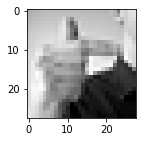

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (2,2))
plt.imshow(X_train_new[11][45].reshape(28,28), cmap="gray")

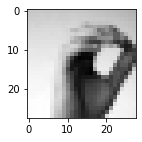

In [19]:
plt.figure(figsize = (2,2))
plt.imshow(X_test_new[23][32].reshape(28,28), cmap="gray")

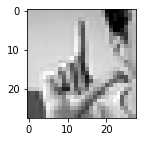

In [41]:
plt.figure(figsize = (2,2))
plt.imshow(X_unseen_new[17][36].reshape(28,28), cmap="gray")

They look pretty bad :p

## Now construct the Loader Class

This class will host all the utilities required for training the **Siamese Neural Network**, including loading batches, training and testing tasks to the network.

In [ ]:
class SiameseLoader:
    
    def __init__(self, data_subsets = ["train", "val", "test"]):
        self.data = {}
        
        self.data['train'] = X_train_new
        self.data['val'] = X_valid_new
        self.data['test'] = X_test_new

    def get_batch(self,batch_size,s="train"):
        #---->Create batch of n pairs, half same class, half different class
        X=self.data[s]
        n_classes, n_examples, w, h, _ = X.shape

        #---->Randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        
        #---->Initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        
        #---->Initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1]
            idx_2 = rng.randint(0, n_examples)
            
            #---->Pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category
            else: 
                #---->Adding a random number to the category to make it different
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2]
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        #---->A batch generator, so that train, val and test generators become available.
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val"):
        #---->Creates pairs of test images and support sets for N-way One-Shot Classification Task
        X=self.data[s]
        n_classes, n_examples, w, h, _ = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        
        #---->Sample random categories for testing
        categories = rng.choice(range(n_classes),size=(N,),replace=False)   
            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        #---->Test average N way oneshot learning accuracy of the network over k one-shot learning tasks
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs=30, batch_size=16, steps_per_epoch=1000, validation_steps=50):
        #---->Training the Network Model using fit_generator
        history = model.fit_generator(
                self.generate(batch_size),
                steps_per_epoch=steps_per_epoch,
                epochs=epochs,
                validation_data=self.generate(batch_size, s="val"),
                validation_steps=validation_steps)
        
        return model
    
    

In [17]:
#---->Create a class object
loader = SiameseLoader()

## Train the Network

Train the network using the train function of **SiameseLoader** util.

In [23]:
siamese_model = loader.train(siamese_net, epochs=60, batch_size=23, validation_steps=600)

Epoch 1/60
1000/1000 [==============================] - 20s 20ms/step - loss: 4.1132 - val_loss: 0.5921
Epoch 2/60
1000/1000 [==============================] - 18s 18ms/step - loss: 0.4774 - val_loss: 0.3494
Epoch 3/60
1000/1000 [==============================] - 18s 18ms/step - loss: 0.3312 - val_loss: 0.3381
Epoch 4/60
1000/1000 [==============================] - 18s 18ms/step - loss: 0.2921 - val_loss: 0.3370
Epoch 5/60
1000/1000 [==============================] - 18s 18ms/step - loss: 0.2538 - val_loss: 0.4044
Epoch 56/60
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0731 - val_loss: 0.0764
Epoch 57/60
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0635 - val_loss: 0.1351
Epoch 58/60
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0621 - val_loss: 0.1115
Epoch 59/60
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0549 - val_loss: 0.0618
Epoch 60/60
1000/1000 [==============================] - 19s

### Quickly Test if the Network is learning anything at all

In [23]:
loader.test_oneshot(siamese_net,24,250,verbose=True)

Evaluating model on 250 random 24 way one-shot learning tasks ...
Got an average of 94.8% 24 way one-shot learning accuracy


94.8

Yes it's learning !

Now let's check the model over k one-shot tasks

## Test the Network over the Test set

And we also check the Nearest Network Accuracy for a better perspective

In [24]:
def nearest_neighbour_correct(pairs,targets):
    #---->returns 1 if nearest neighbour gets the correct answer for a one-shot task given by (pairs, targets).
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    #---->Returns accuracy of one shot over Nearest Neighbour task.
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 24, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    #---->Get the val accs , test accs and train accs into lists for plotting stuff
    val_accs.append(loader.test_oneshot(siamese_model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))

Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ...


C:\Users\Richeek Das\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


Got an average of 99.33333333333333% 3 way one-shot learning accuracy
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 100.0% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 98.22222222222223% 5 way one-shot learning accuracy
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 100.0% 5 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 5 way one-shot learning tasks ...
Evaluating model on 450 random 7 way one-shot learning tasks ...
Got an average of 98.44444444444444% 7 way one-shot learning accuracy
Evaluating model on 450 random 7 way one-shot learning tasks ...
Got an average of 100.0% 7 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 7 way one-shot learning tasks ...
Evaluating model on 450 random 9 way one-shot learning tasks

## What's a model without some plots ?

Here, you can find the plot of train acc and val acc, as an example. You can find more plots in the [README](https://github.com/sudoRicheek/Siamese-Net-One-Shot-Learning/blob/master/README.md).

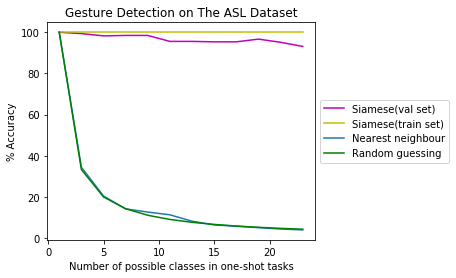

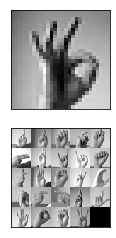

In [25]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Gesture Detection on The ASL Dataset")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(24,"val")
plt.show()
plot_oneshot_task(inputs)

## Let's save the model weights and the model architecture

In [20]:
weights_path = "C:/Users/Richeek Das/Downloads/siamese_layer_drop_eightdata.h5"
json_path = "C:/Users/Richeek Das/Downloads/arch_layer_drop_eight_data.json"

In [46]:
print("saving")            
siamese_model.save_weights(weights_path)
model_json = siamese_model.to_json()

with open(json_path, "w") as json_file:
    json_file.write(model_json)

saving
